## Group 2
U2221439J - Leck Boon Keng

U2220711G - Eileen Paw Zhang Hui

U2220994B - xinyu Feng

# Quiz (Week 4): 
Using Opentrons and active learning to produce a color of choice. 
The color should be the last 3 digits of your student ID. Each student contribute to 1 channel of R, G, B. 

Submit your homework with Name and student ID to the github repo


In [21]:
import os
import re
import json
import time
import math
import requests
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from opentrons import protocol_api
from pathlib import Path

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from scipy.optimize import minimize
import scipy

# 1. Connecting to Opentrons (0 points, no mark)

In [25]:
# Setup & Check Robot Connectivity
ROBOT_IP = "169.254.91.213"  # Replace with your robot's IP address, 169.254.91.213
BASE_URL = f"http://{ROBOT_IP}:31950"
HEADERS = {"Opentrons-Version": "*"}

try:
    response = requests.get(f"{BASE_URL}/health", headers=HEADERS, timeout=5)
    if response.ok:
        print("BEARS Robot is healthy:", response.json())
    else:
        print("Failed to connect to the robot. Status code:", response.status_code)
except requests.exceptions.RequestException as e:
    print("Error connecting to the robot:", e)

BEARS Robot is healthy: {'name': 'OpenHeimer', 'robot_model': 'OT-2 Standard', 'api_version': '8.5.1', 'fw_version': 'v1.1.0-25e5cea', 'board_revision': 'A', 'logs': ['/logs/serial.log', '/logs/api.log', '/logs/server.log', '/logs/update_server.log'], 'system_version': 'v1.18.2', 'maximum_protocol_api_version': [2, 24], 'minimum_protocol_api_version': [2, 0], 'robot_serial': 'OT2CEP20220627R11', 'links': {'apiLog': '/logs/api.log', 'serialLog': '/logs/serial.log', 'serverLog': '/logs/server.log', 'apiSpec': '/openapi.json', 'systemTime': '/system/time'}}


# 2. Construct a color mixing protocol to initiate active learning (40 points)

A. Please generate a few starting point (colors) and a target color.  
B. Prepare them using Opentrons protocol.  
C. Capture an image.  
D. Acquire respective ROIs.

In [176]:
# Upload protocol to opentrons
protocol_file_path = "protocol_run5.py"
with open(protocol_file_path, 'rb') as file:
    files = {'files': (protocol_file_path, file)}
    response = requests.post(f"{BASE_URL}/protocols", headers=HEADERS, files=files)

# Check for successful update of protocol
if response.ok:
    protocol_id = response.json()["data"]["id"]
    print("Protocol uploaded successfully. Protocol ID:", protocol_id)
else:
    print("Failed to upload protocol. Status code:", response.status_code)
    print("Response:", response.text)

Protocol uploaded successfully. Protocol ID: c08ef6df-8fca-4b72-a719-7a1a71c743b7


In [177]:
# Create a new run
run_response = requests.post(f"{BASE_URL}/runs", headers=HEADERS, json={"data": {"protocolId": protocol_id}})
if run_response.ok:
    run_id = run_response.json()["data"]["id"]
    print("Run created successfully. ID:", run_id)
else:
    print("Failed to create run. Status code:", run_response.status_code)
    print("Response:", run_response.text)

Run created successfully. ID: 17714131-e9ae-471e-a496-5c0fa0ee9caf


In [178]:
# Start the run
start_response = requests.post(f"{BASE_URL}/runs/{run_id}/actions", headers=HEADERS, json={"data": {"actionType": "play"}})
if start_response.ok:
    print("Run started successfully.")
else:
    print("Failed to start run. Status code:", start_response.status_code)
    print("Response:", start_response.text)

Run started successfully.


<b>Run this code only after the starting protocols have been collected</b>

In [179]:
# Image processing functions
def capture_image(BASE_URL, HEADERS, filename="captured_image.jpg"):
    """Capture image from robot camera"""
    resp = requests.post(f"{BASE_URL}/camera/picture", headers=HEADERS)
    if resp.ok:
        with open(filename, "wb") as f:
            f.write(resp.content)
        print(f"📸 Image saved: {filename}")
        return filename
    else:
        print("❌ Failed to capture image.")
        return None

def crop_plate(image_path, out_path="cropped.jpg", crop_box=(430, 15, 610, 150)):
    """Crop plate region from full camera image"""
    image = Image.open(image_path).convert("RGB")
    cropped = image.crop(crop_box)
    cropped.save(out_path)
    print(f"🟩 Cropped image saved: {out_path}")
    pix = np.array(cropped)
    return cropped, pix

def slice_rois(pix, rows=8, cols=12, offset=((5, 6), (6, 7))):
    """Slice plate image into individual well ROIs"""
    h, w, _ = pix.shape
    dh, dw = h // rows, w // cols
    rois = []
    for r in range(rows):
        for c in range(cols):
            y1 = r*dh + offset[1][0]
            y2 = (r+1)*dh - offset[1][1]
            x1 = c*dw + offset[0][0]
            x2 = (c+1)*dw - offset[0][1]
            rois.append(pix[y1:y2, x1:x2])
    return rois

def save_rois_and_metadata(rois, base_image_id, metadata, base_dir="output"):
    """Save individual ROI images and metadata"""
    os.makedirs(base_dir, exist_ok=True)
    img_dir = os.path.join(base_dir, f"dispense_{base_image_id}")
    os.makedirs(img_dir, exist_ok=True)

    meta_path = os.path.join(img_dir, "metadata.json")
    with open(meta_path, "w") as f:
        json.dump(metadata, f, indent=2)

    for i, roi in enumerate(rois):
        img = Image.fromarray(roi.astype(np.uint8))
        roi_path = os.path.join(img_dir, f"roi_{i+1:02d}.jpg")
        img.save(roi_path)
    
    npy_path = os.path.join(img_dir, "rois.npy")
    np.save(npy_path, rois)

    print(f"🧬 Saved {len(rois)} ROIs to: {img_dir}")

# Monitor protocol status and capture images
seen_command_ids = set()
last_dispense_cmd = None

while True:
    # --- get run status ---
    run_resp = requests.get(f"{BASE_URL}/runs/{run_id}", headers=HEADERS)
    if not run_resp.ok:
        print("Failed to get run status:", run_resp.status_code)
        break

    status = run_resp.json()["data"]["status"]
    print("Current run status:", status)

    # --- get new commands ---
    cmd_resp = requests.get(f"{BASE_URL}/runs/{run_id}/commands", headers=HEADERS)
    if not cmd_resp.ok:
        print("Failed to get commands:", cmd_resp.status_code)
        break

    for cmd in cmd_resp.json()["data"]:
        cid = cmd["id"]
        if cid in seen_command_ids:
            continue
        seen_command_ids.add(cid)

        ctype = cmd.get("commandType", "")
        params = cmd.get("params", {})
        volume = params.get("volume")
        location = params.get("labware") or params.get("well")

        if ctype in ("aspirate", "dispense") and volume is not None:
            print(f"🔄 {ctype.capitalize()}  Volume: {volume} µL  |  Location: {location}")

            if ctype == "dispense":
                last_dispense_cmd = {
                    "id": cid,
                    "volume": volume,
                    "location": location
                }

    # --- exit when run finishes ---
    if status in ("succeeded", "failed", "stopped"):
        print(f"✅ Protocol {status}.")
        break

    time.sleep(5)

# --- process only the last dispense image ---
if last_dispense_cmd:
    cid = last_dispense_cmd["id"]
    volume = last_dispense_cmd["volume"]
    location = last_dispense_cmd["location"]
    print(f"\n📌 Capturing only the last dispense (ID: {cid})")

    raw_name = f"dispense_image.jpg"
    img_path = capture_image(BASE_URL, HEADERS, filename=raw_name)

    if img_path:
        # Proceed with image correction + cropping
        # First, process the captured image
        cropped_image, pix = crop_plate(img_path, out_path="cropped_dispense.jpg")
        
        # Now extract ROIs from the processed image
        rois = slice_rois(pix)

        save_rois_and_metadata(
            rois=rois,
            base_image_id=cid,
            metadata={"volume": volume, "location": location}
        )

time.sleep(5)

Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
🔄 Aspirate  Volume: 220.0 µL  |  Location: None
Current run status: running
🔄 Dispense  Volume: 220.0 µL  |  Location: None
Current run status: running
Current run status: running
Current run status: running
Current run status: running
Current run status: running
🔄 Aspirate  Volume: 80.0 µL  |  Location: None
Current run status: running
🔄 Dispense  Volume: 80.0 µL  |  Location: None
Current run status: running
Current run status: running
Current run status: finishing
Current run status: finishing
Current run status: succeeded
✅ Protocol succeeded.

📌 Capturing only the last dispense (ID: command.DISPENSE-1)
📸 Image saved: dispense_image.jpg
🟩 Cropped image saved: cropped_dispense.jpg
🧬 Saved 96 ROIs to: output\dispense_command.DISPENSE-1


C:\Users\bklec\AppData\Local\Temp\ipykernel_15216\230708757.py:7: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')


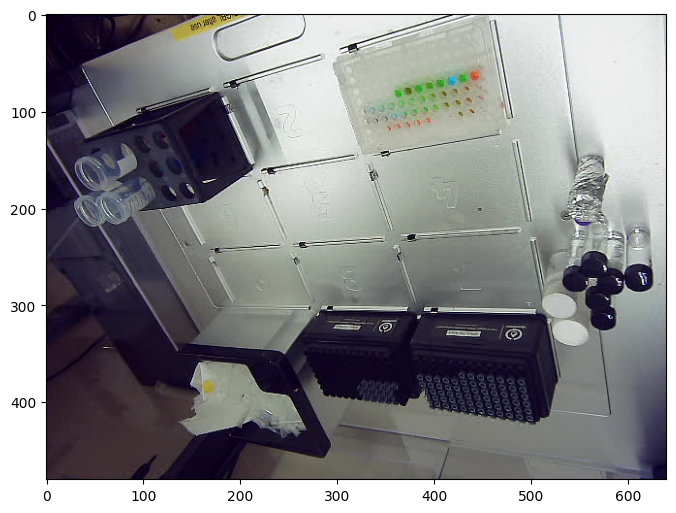

In [180]:
# Read captured image from Opentrons
pic_folder = '.' 
for img in os.listdir(pic_folder):
    if img.endswith("dispense_image.jpg"):
        image_path = os.path.join(pic_folder, img)
        image = Image.open(image_path, 'r')
        im = Image.fromarray(np.array(image, dtype=np.uint8), 'RGB')
        # Proceed with image processing

        # Create figure and axes
        fig,ax = plt.subplots(1,figsize=(8,8))
        
        # Display the image
        ax.imshow(im)
        plt.show()

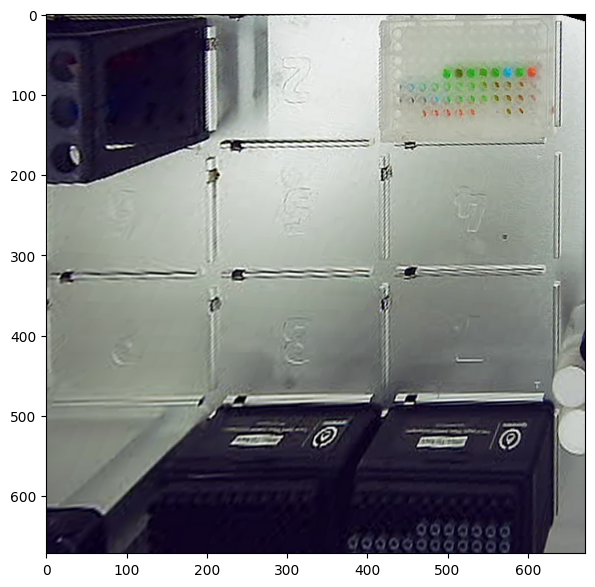

In [181]:
def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=float)  # <-- fixed here
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

img = image
width, height = img.size
m = -0.1
n = 0.1
xshift = abs(m) * width
yshift = abs(n) * height
new_width = width + int(round(xshift))
new_height = height +int(round(yshift))
final_coeffs = [(94, 101), (460, 0), (520, 309), (196, 301)]  # Start with current
final_crop = (431, 14, 608, 150)
coeffs = find_coeffs(
        [(0, 0), (640, 0), (640, 480), (0, 480)],
        final_coeffs)

img_corr = img.transform((int(width*1.05), int(height*1.4)), Image.PERSPECTIVE, coeffs, Image.BICUBIC)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(img_corr)
plt.show()

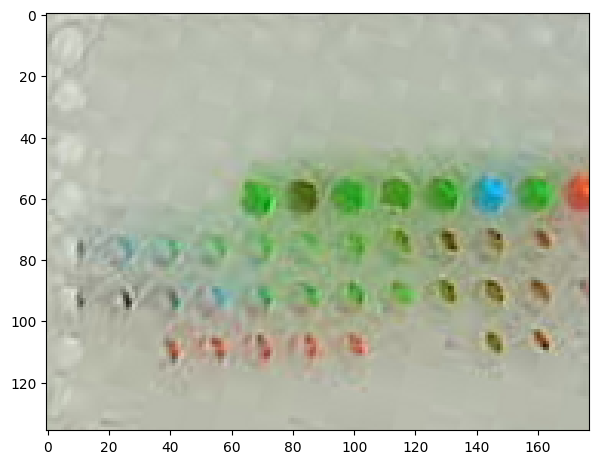

In [182]:
crop_box= final_crop
image_cropped = img_corr.crop(box=crop_box) #box=(left, upper, right, lower)

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(7,7))
# Display the image
ax.imshow(image_cropped)
plt.show()

In [183]:
import matplotlib.patches as patches

def get_image_array(image, crop_box):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = image.crop(box=crop_box) #box=(left, upper, right, lower)
    [width,height] = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((height, width, channels))
    return (width,height,pixel_values)

def image_slicing(image_array, col_num,row_num, offset_array):
    """slice the ROIs from an image of an array of samples/colorcard"""
    row_h = int(np.round(image_array.shape[0]/row_num))
    col_w = int(np.round(image_array.shape[1]/col_num))
    
    fig,ax = plt.subplots(1,figsize=(8,8))
    images = []
    imagecol = []
    for y in np.arange(row_num):
        imagerow = []
        for x in np.arange(col_num):
            # slicing indices for each color square
            y1 = row_h*y+offset_array[1][0]
            y2 = row_h*(y+1)-offset_array[1][1]
            x1 = col_w*x+offset_array[0][0]
            x2 = col_w*(x+1)-offset_array[0][1]
            image = image_array[y1:y2,x1:x2]
            imagerow.append(image)# append every images in a row into a row list
            images.append(image)# append every images into a list
            
            
            # Add the rectangular patch to the Axes
            lw=1 # Line width
            ec='r' # edge color
            fc='none' # face color
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,
                                      linewidth=lw,edgecolor=ec,facecolor=fc)
            ax.add_patch(rect)

            roi_number = y * col_num + x + 1           # 1-based index
            cx = (x1 + x2) / 2                         # centre X
            cy = (y1 + y2) / 2                         # centre Y
            ax.text(cx, cy, str(roi_number),
                    color='yellow', fontsize=6,
                    ha='center', va='center')          # place label
    
        imagecol.append(np.concatenate(imagerow, axis=1))
    image_reconstr = np.array(np.concatenate(imagecol, axis=0), dtype=np.uint8)

    return [fig, ax, image_reconstr, images]


In [184]:
w, h, image_array = get_image_array(img_corr, crop_box)
              
# Row, Columns Settings and Offset pixels for each sample (TO BE CHANGED)
row_num=8
col_num=12
offset_array= [[5,6],[6,7]] #[[x_left,x_right],[y_upper,y_lower]]
[fig_ROI, ax_ROI, reconstr_ROI, image_ROI]= image_slicing(
        image_array, col_num, row_num, offset_array)
ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))
fig_ROI.savefig(os.path.join(pic_folder, "reconstructed_with_boxes.jpg"))
plt.show()

C:\Users\bklec\AppData\Local\Temp\ipykernel_15216\1043717840.py:9: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  ax_ROI.imshow(Image.fromarray(np.array(image_array, dtype=np.uint8), 'RGB'))


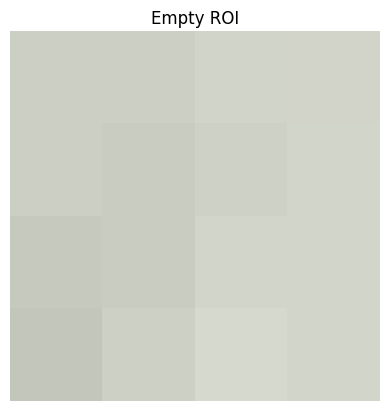

In [185]:
empty_roi = image_ROI[0]
empty_rgb = np.mean(empty_roi, axis=(1, 2))

plt.imshow(empty_roi)
plt.title("Empty ROI")
plt.axis("off")
plt.show()

In [186]:
image = Image.open("captured_image.jpg").convert("RGB")

# Convert to NumPy array
np_image = np.array(image)

# Average RGB across all pixels
avg_rgb = np.mean(np_image, axis=(0, 1))  # shape: (3,)
print(f"Average RGB: {avg_rgb}")

Average RGB: [110.47899414 109.9201888  113.62049805]


In [187]:
for i, roi in enumerate(image_ROI):  # each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    print(f"ROI {i+1} Average RGB: {rgb_avg}")

ROI 1 Average RGB: [205.6875 208.625  197.625 ]
ROI 2 Average RGB: [190.0625 194.0625 180.    ]
ROI 3 Average RGB: [184.4375 188.4375 174.4375]
ROI 4 Average RGB: [186.    192.125 178.125]
ROI 5 Average RGB: [188.0625 192.25   178.25  ]
ROI 6 Average RGB: [189.5 193.5 179.5]
ROI 7 Average RGB: [182.625  188.6875 174.6875]
ROI 8 Average RGB: [184.5    189.9375 175.9375]
ROI 9 Average RGB: [183. 189. 175.]
ROI 10 Average RGB: [182.375  187.4375 175.875 ]
ROI 11 Average RGB: [182.875  188.875  178.9375]
ROI 12 Average RGB: [181.     187.0625 177.0625]
ROI 13 Average RGB: [210.3125 213.3125 202.3125]
ROI 14 Average RGB: [190.8125 193.6875 182.8125]
ROI 15 Average RGB: [187.6875 191.4375 178.625 ]
ROI 16 Average RGB: [187.1875 193.1875 179.1875]
ROI 17 Average RGB: [185.5625 191.5625 177.5625]
ROI 18 Average RGB: [183.8125 189.8125 175.8125]
ROI 19 Average RGB: [185.75   191.6875 177.75  ]
ROI 20 Average RGB: [182.0625 190.0625 175.0625]
ROI 21 Average RGB: [181.9375 189.25   174.375 ]
ROI 

ROI 1 Average RGB: [205.6875 208.625  197.625 ]
ROI 2 Average RGB: [190.0625 194.0625 180.    ]
ROI 3 Average RGB: [184.4375 188.4375 174.4375]
ROI 4 Average RGB: [186.    192.125 178.125]
ROI 5 Average RGB: [188.0625 192.25   178.25  ]
ROI 6 Average RGB: [189.5 193.5 179.5]
ROI 7 Average RGB: [182.625  188.6875 174.6875]
ROI 8 Average RGB: [184.5    189.9375 175.9375]
ROI 9 Average RGB: [183. 189. 175.]
ROI 10 Average RGB: [182.375  187.4375 175.875 ]
ROI 11 Average RGB: [182.875  188.875  178.9375]
ROI 12 Average RGB: [181.     187.0625 177.0625]
ROI 13 Average RGB: [210.3125 213.3125 202.3125]
ROI 14 Average RGB: [190.8125 193.6875 182.8125]
ROI 15 Average RGB: [187.6875 191.4375 178.625 ]
ROI 16 Average RGB: [187.1875 193.1875 179.1875]
ROI 17 Average RGB: [185.5625 191.5625 177.5625]
ROI 18 Average RGB: [183.8125 189.8125 175.8125]
ROI 19 Average RGB: [185.75   191.6875 177.75  ]
ROI 20 Average RGB: [182.0625 190.0625 175.0625]
ROI 21 Average RGB: [181.9375 189.25   174.375 ]
ROI 

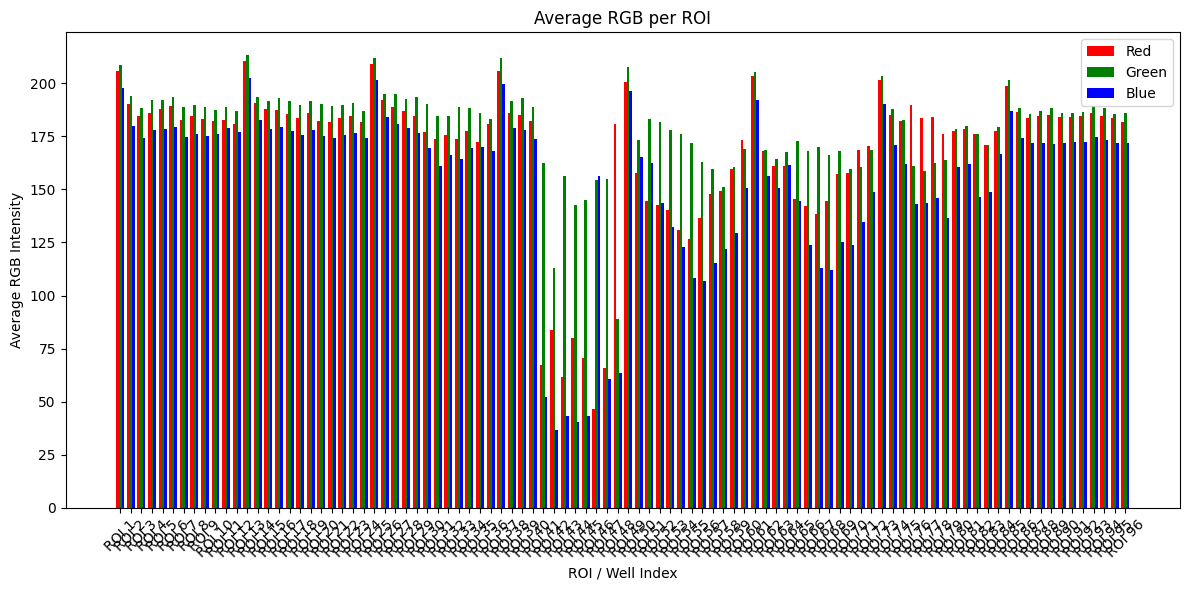

In [188]:
# Collect average RGBs for each ROI
avg_rgbs = []
for i, roi in enumerate(image_ROI):  # each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    avg_rgbs.append(rgb_avg)
    print(f"ROI {i+1} Average RGB: {rgb_avg}")

# Convert to NumPy array
avg_rgbs = np.array(avg_rgbs)  # shape: (num_rois, 3)
r_vals = avg_rgbs[:, 0]
g_vals = avg_rgbs[:, 1]
b_vals = avg_rgbs[:, 2]

# Bar plot settings to see each ROI's RGB values 
x = np.arange(len(image_ROI))  # Index for each ROI
width = 0.25  # Width of each bar

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, r_vals, width, color='red', label='Red')
ax.bar(x, g_vals, width, color='green', label='Green')
ax.bar(x + width, b_vals, width, color='blue', label='Blue')

# Formatting
ax.set_xlabel("ROI / Well Index")
ax.set_ylabel("Average RGB Intensity")
ax.set_title("Average RGB per ROI")
ax.set_xticks(x)
ax.set_xticklabels([f"ROI {i+1}" for i in x], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


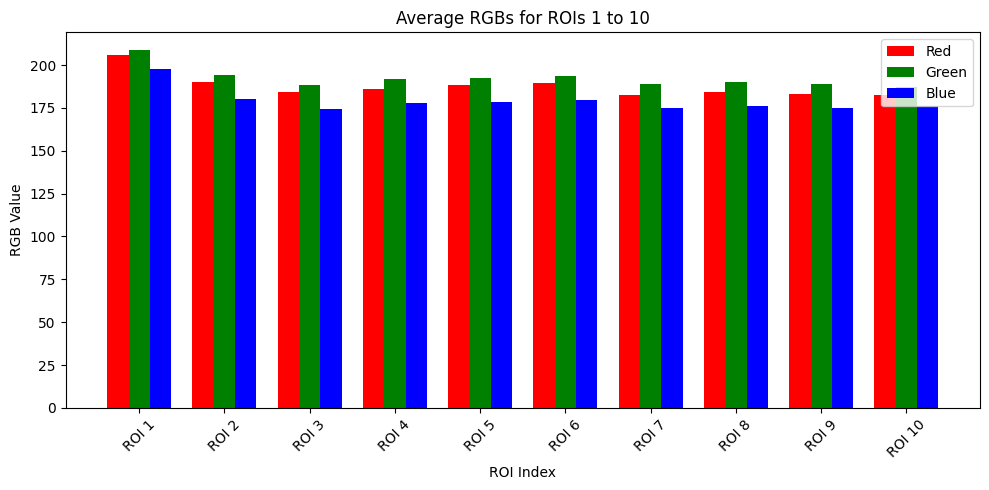

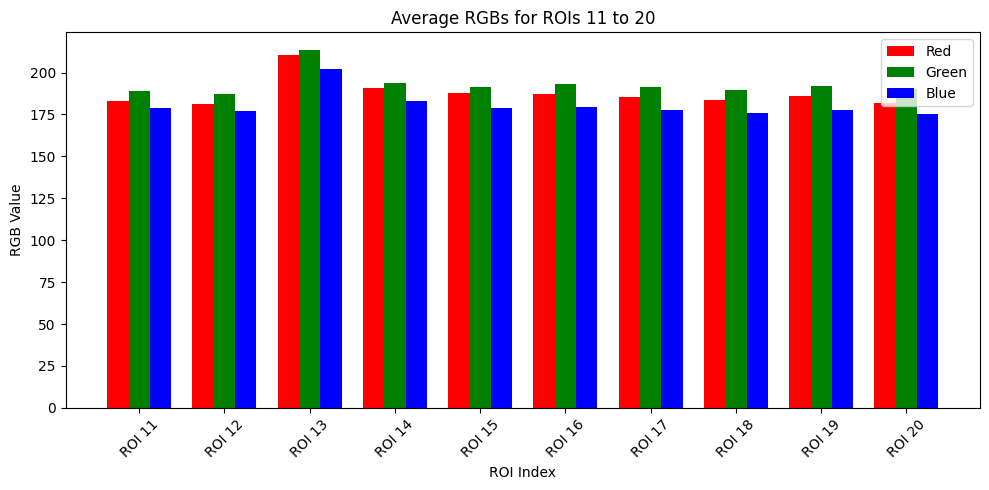

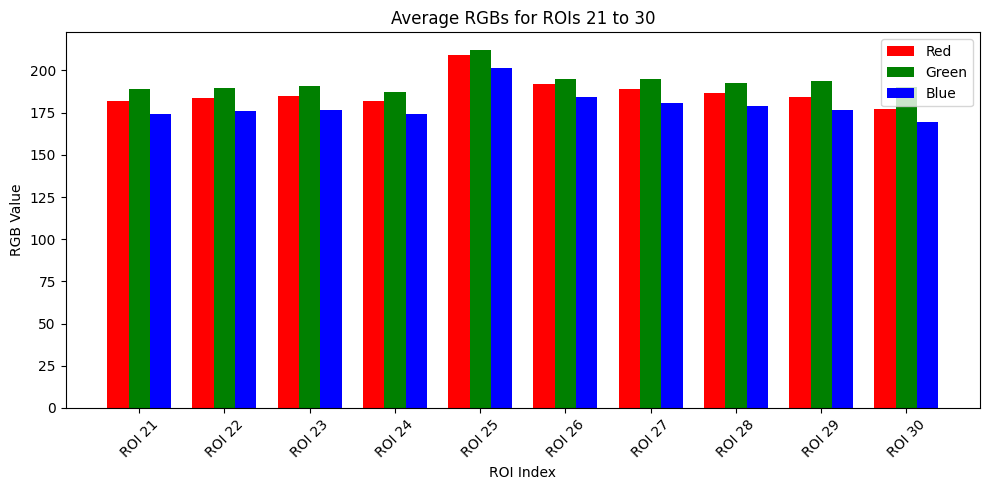

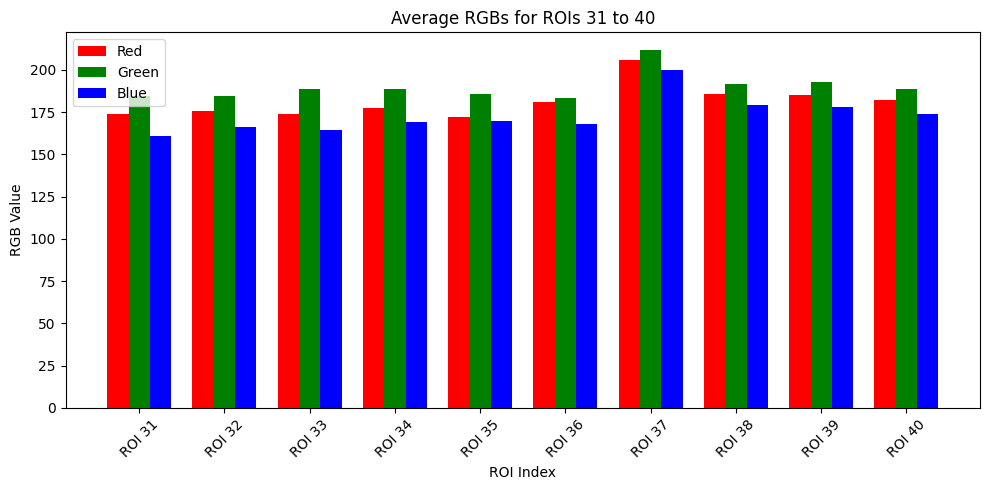

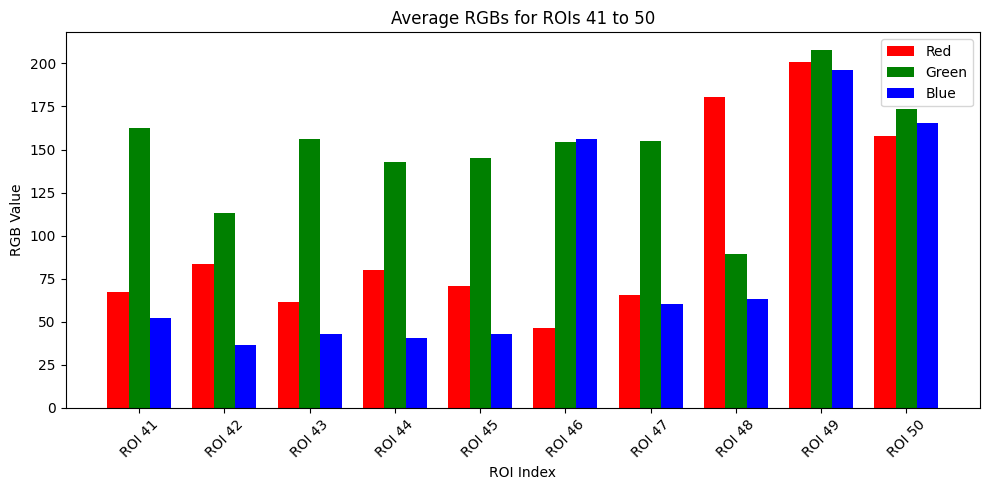

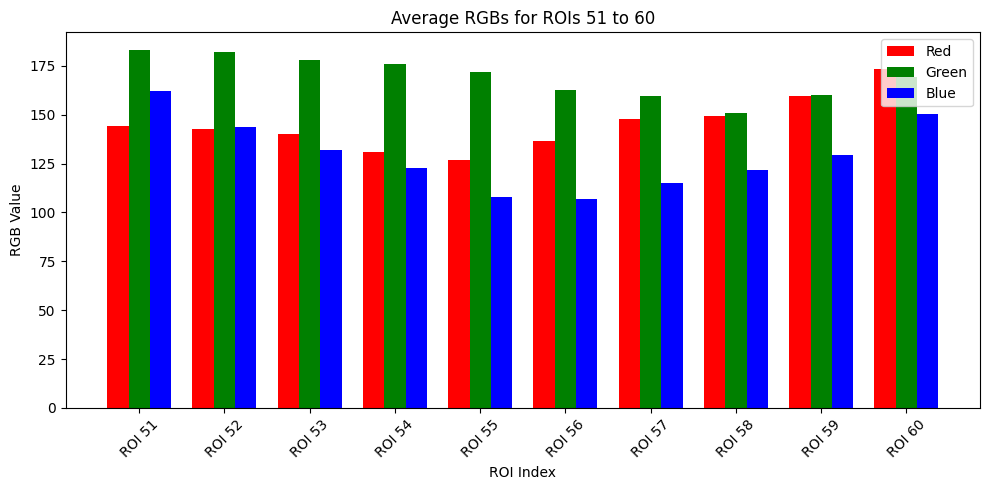

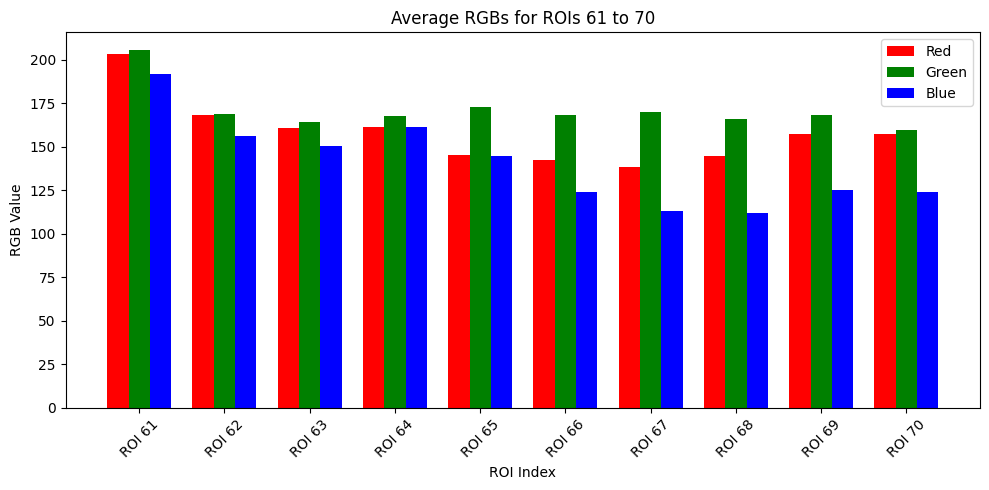

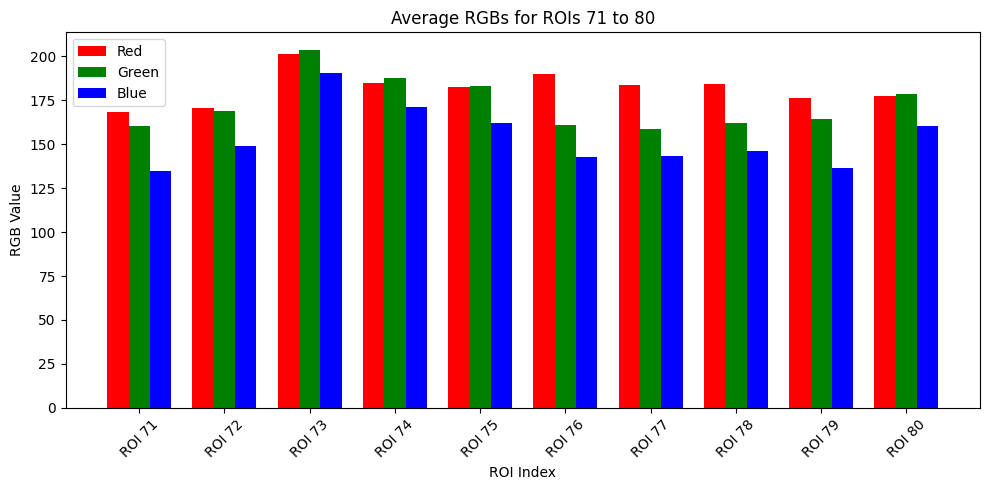

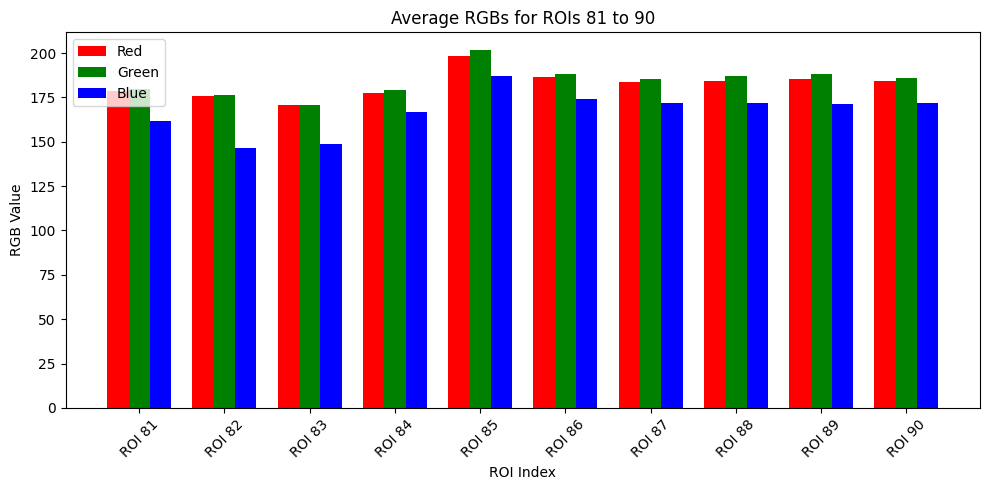

In [189]:
# --- Step 1: Compute average RGBs ---
avg_rgbs = []
for i, roi in enumerate(image_ROI):  # assuming each `roi` is a PIL Image
    rgb_avg = np.mean(np.array(roi), axis=(0, 1))
    avg_rgbs.append(rgb_avg)

avg_rgbs = np.array(avg_rgbs)  # shape: (num_rois, 3)

# --- Step 2: Plot in chunks of 10 ROIs ---
def plot_rgb_chunks(avg_rgbs, chunk_size=10):
    num_chunks = int(np.ceil(len(avg_rgbs) / chunk_size))

    for c in range(num_chunks):
        start = c * chunk_size
        end = min((c + 1) * chunk_size, len(avg_rgbs))
        chunk = avg_rgbs[start:end]

        r_vals = chunk[:, 0]
        g_vals = chunk[:, 1]
        b_vals = chunk[:, 2]
        x = np.arange(len(chunk))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(x - width, r_vals, width, color='red', label='Red')
        ax.bar(x, g_vals, width, color='green', label='Green')
        ax.bar(x + width, b_vals, width, color='blue', label='Blue')

        ax.set_title(f"Average RGBs for ROIs {start + 1} to {end}")
        ax.set_xlabel("ROI Index")
        ax.set_ylabel("RGB Value")
        ax.set_xticks(x)
        ax.set_xticklabels([f"ROI {i+1}" for i in range(start, end)], rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

# --- Step 3: Call the function ---
plot_rgb_chunks(avg_rgbs, chunk_size=10)

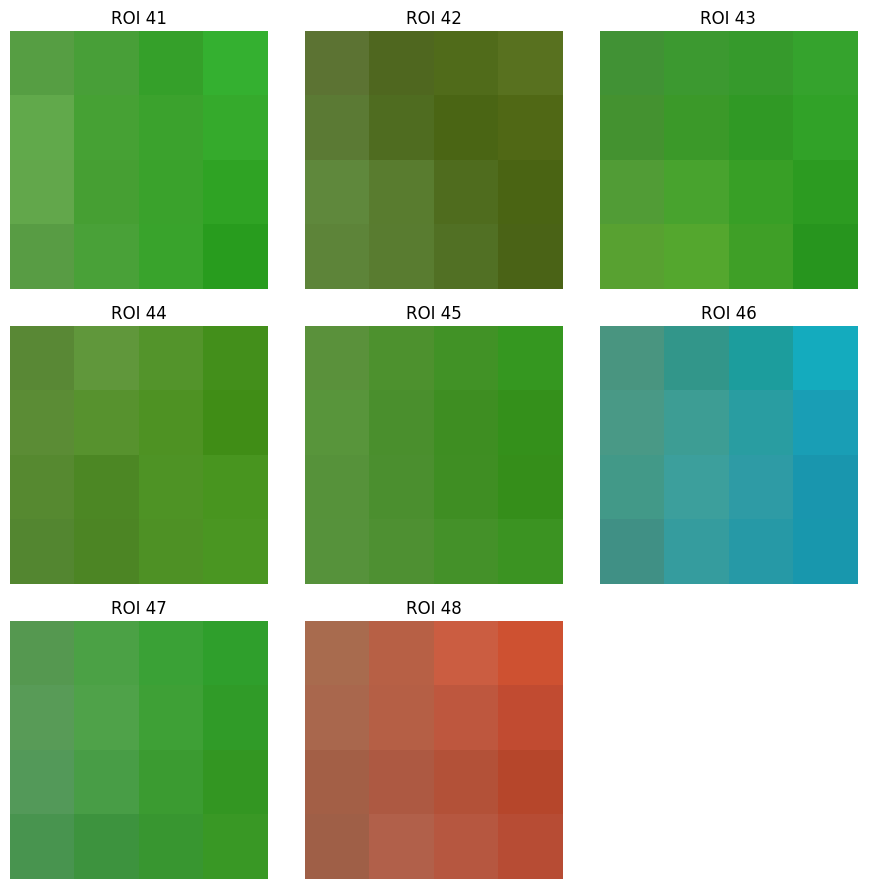

In [193]:
# Things to change on the day itself
# INITIAL_POINTS should correspond to that in protocol_starting.py
START_ROI = 40
END_ROI = 48
INITIAL_POINTS = [
    (0, 220, 80),
    (85, 130, 85),
    (0, 235, 65),
    (55, 245, 0),
    (20, 250, 30),
    (0, 0, 300),
    (0, 300, 0),
    (300, 0, 0),
]
subset = image_ROI[START_ROI:END_ROI]

# choose a grid size (e.g. 3 columns)
cols = 3
rows = math.ceil(len(subset) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

for idx, ax in enumerate(axes.flat):
    if idx < len(subset):
        roi_num = START_ROI + idx + 1        # 1-based ROI number
        ax.imshow(subset[idx])
        ax.set_title(f"ROI {roi_num}")
        ax.axis("off")
    else:
        ax.axis("off")  # hide empty cells

plt.tight_layout()
plt.show()

In [194]:
# Save the values into a csv file
# Make sure INITIAL_POINTS matches the number of ROIs
if len(INITIAL_POINTS) != len(subset):
    raise ValueError("INITIAL_POINTS length must match number of ROIs in subset")

# Save data into the respective columns for BO
data = []
for idx, roi in enumerate(subset):
    volR, volG, volB = INITIAL_POINTS[idx]
    avgR, avgG, avgB = np.mean(np.array(roi), axis=(0,1))
    data.append([volR, volG, volB, avgR, avgG, avgB])

# Save to CSV
df = pd.DataFrame(data, columns=["volumeR", "volumeG", "volumeB", "averageR", "averageG", "averageB"])
df.to_csv("data/BO_run5.csv", index=False)
print("CSV saved successfully.")

CSV saved successfully.


In [215]:
START_ROI = 40
END_ROI = 48
subset = image_ROI[START_ROI:END_ROI]

# Reverse the subset so first plotted image = ROI48
subset = subset[::-1]

rows, cols = 1, len(subset)                   # one row, N columns
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3))  # width scales with count

for idx, ax in enumerate(axes.flat):
    if idx < len(subset):
        ax.imshow(subset[idx])
        ax.set_title(f"Run {idx+1}")   # label sequentially as Run 1, Run 2...
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

# 3. Produce the target color in wellplate (40 points) 
Target RGB values (55,150,40).  
You should try to approach the target color as fast as possible, within minimum number of sample prepared. 

Hint: During the optimization process, the amount of liquid transferred differs between runs. So we need to automate the protocol generation process. 

protocol_generator.py and  bo_loop_example.py  might be a good reference (It is a working code generated from LLM, try beat it in you own implementation)

### Run this code only after the starting protocols have been collected

In [195]:
# Things to change dynamically
PREV_RUN_NUMBER = 5
PREV_CSV_PATH = Path(f"data/BO_run{PREV_RUN_NUMBER}.csv")   # your accumulated results

# Define parameters for Bayesian Optimisation
TARGET_RGB = np.array([55, 150, 40])
NEXT_RUN_NUMBER = PREV_RUN_NUMBER + 1
PROTOCOL_TEMPLATE_PATH = Path(f"protocol_run{PREV_RUN_NUMBER}.py")  # previous protocol
OUTPUT_DIR = Path("protocols")  # directory to save new protocols
OUTPUT_DIR.mkdir(exist_ok=True)

In [ ]:
df = pd.read_csv(PREV_CSV_PATH)
print(f"✅ Loaded CSV data from {PREV_CSV_PATH}")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(df)

# Inputs: volumes
X = df[['volumeR', 'volumeG', 'volumeB']].values

# Output: negative distance so that *higher* is better -> GPR frames it as a maximisation problem, so we maximise towards zero
Y = -np.linalg.norm(df[['averageR','averageG','averageB']].values - TARGET_RGB, axis=1).reshape(-1,1)

# --- Fit GP model ---
kernel = ConstantKernel(1.0) * Matern(length_scale=50.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gpr.fit(X, Y)

# --- Expected Improvement (vectorized) ---
def expected_improvement(X_candidates):
    mu, sigma = gpr.predict(X_candidates, return_std=True)
    mu_sample_opt = Y.max()
    sigma = np.maximum(sigma, 1e-9)  # avoid division by zero
    Z = (mu - mu_sample_opt) / sigma
    ei = (mu - mu_sample_opt) * scipy.stats.norm.cdf(Z) + sigma * scipy.stats.norm.pdf(Z)
    return ei

# --- Define bounds and step ---
R_MAX, G_MAX, B_MAX = 150, 250, 150
R_vals = np.arange(0, R_MAX + 1, 5)   # 0, 5, 10
G_vals = np.arange(0, G_MAX + 1, 5)   # 0, 5, 10
B_vals = np.arange(0, B_MAX + 1, 5)   # 0, 5, 10

all_candidates = np.array(
    [(r, g, b)
     for r in R_vals
     for g in G_vals
     for b in B_vals
     if r + g + b == 300]
)

mu, sigma = gpr.predict(all_candidates, return_std=True)
weights = sigma        # or combine: alpha*mu + beta*sigma
weights /= weights.sum()
idx = np.random.choice(len(all_candidates), 400, replace=False, p=weights)
X_candidates = all_candidates[idx]

ei = expected_improvement(X_candidates)
best_idx = np.argmax(ei)
best_x = tuple(map(int, X_candidates[best_idx]))
print("Next suggested volumes (ml):", best_x)

✅ Loaded CSV data from data\BO_run5.csv
Data shape: (8, 6)
Columns: ['volumeR', 'volumeG', 'volumeB', 'averageR', 'averageG', 'averageB']
   volumeR  volumeG  volumeB  averageR  averageG  averageB
0        0      220       80   67.0625  162.6250   52.0625
1       85      130       85   83.5625  113.0000   36.4375
2        0      235       65   61.4375  156.1875   43.1875
3       55      245        0   79.8750  142.5625   40.3125
4       20      250       30   70.5625  145.0000   43.1250
5        0        0      300   46.6875  154.5625  156.1250
6        0      300        0   65.8125  154.8125   60.5625
7      300        0        0  180.6875   89.1250   63.3750
Next suggested volumes (ml): (140, 160, 0)


In [197]:
# --- Read previous protocol ---
text = PROTOCOL_TEMPLATE_PATH.read_text()

# --- Update POINTS ---
text = re.sub(r"POINTS\s*=\s*\[.*\]", f"POINTS = [{best_x}]", text)

# --- Update RUN_NUMBER ---
text = re.sub(r"RUN_NUMBER\s*=\s*\d+", f"RUN_NUMBER = {NEXT_RUN_NUMBER}", text)

# --- Save new protocol file ---
new_protocol_path = Path(f"protocol_run{NEXT_RUN_NUMBER + 1}.py")
new_protocol_path.write_text(text)
print(f"✅ Created new protocol file: {new_protocol_path}")

✅ Created new protocol file: protocol_run7.py


# 4. Visualize the optimizaition (20 points)  
A. Visualize the difference between target color and prepared color mixture. 
B. Visualize the machine learning process. 

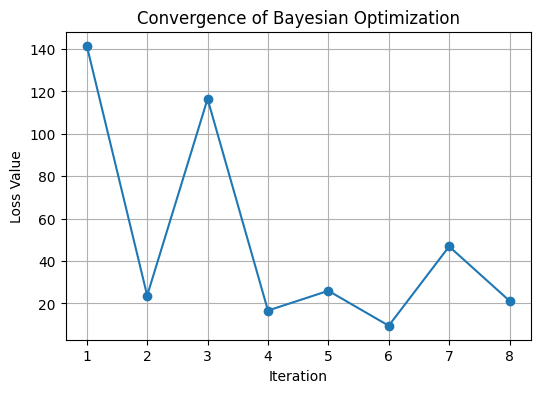

In [219]:
pred_Y, _ = gpr.predict(X, return_std=True)
loss = pred_Y[::-1] # pred_Y is saved in reverse
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pred_Y)+1), -loss, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Convergence of Bayesian Optimization")
plt.grid(True)
plt.show()

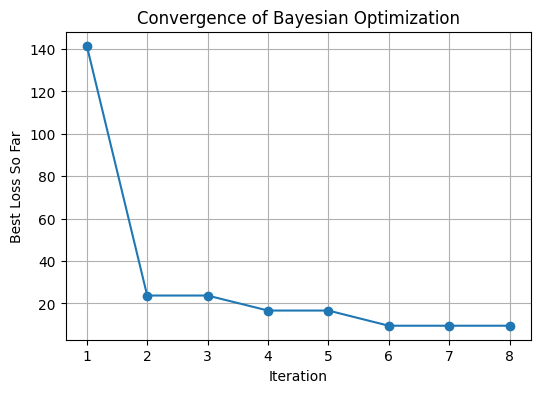

In [217]:
loss_vals = -pred_Y[::-1].ravel()   # shape (n,)

# Running minimum: best (lowest) loss so far at each iteration
best_loss = np.minimum.accumulate(loss_vals)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(best_loss)+1), best_loss, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Loss So Far")
plt.title("Convergence of Bayesian Optimization")
plt.grid(True)
plt.show()

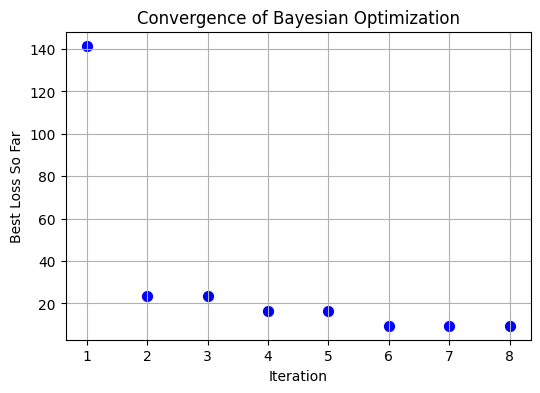

In [218]:
plt.figure(figsize=(6,4))
plt.scatter(range(1, len(best_loss)+1), best_loss, c='blue', s=50)
plt.xlabel("Iteration")
plt.ylabel("Best Loss So Far")
plt.title("Convergence of Bayesian Optimization")
plt.grid(True)
plt.show()

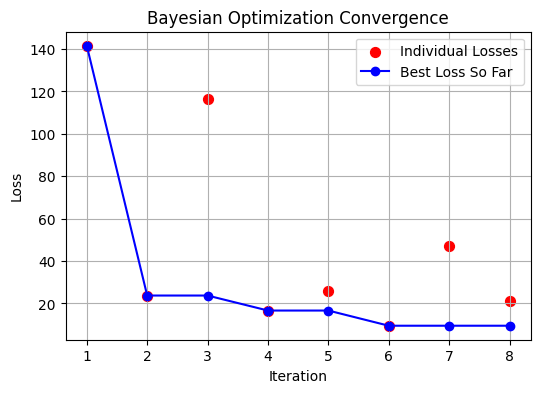

In [221]:
pred_Y, _ = gpr.predict(X, return_std=True)

# Reverse order and convert to positive loss
loss_vals = -pred_Y[::-1].ravel()

# Running minimum (best loss so far)
best_loss = np.minimum.accumulate(loss_vals)

plt.figure(figsize=(6,4))
# Scatter of all individual points
plt.scatter(range(1, len(loss_vals)+1), loss_vals, c='red', label='Individual Losses', s=50)
# Line for cumulative minimum
plt.plot(range(1, len(best_loss)+1), best_loss, c='blue', marker='o', label='Best Loss So Far')

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Bayesian Optimization Convergence")
plt.legend()
plt.grid(True)
plt.show()